# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-2.381834,True,-0.012711
1,0.242480,True,5.821157
2,-0.117542,True,5.860776
3,-0.579126,False,-0.605553
4,-1.655410,False,-2.608667
...,...,...,...
995,0.435876,True,5.795862
996,-0.124481,False,-0.328659
997,-1.252306,False,-2.091580
998,0.964004,False,1.067315


<Axes: xlabel='v0'>

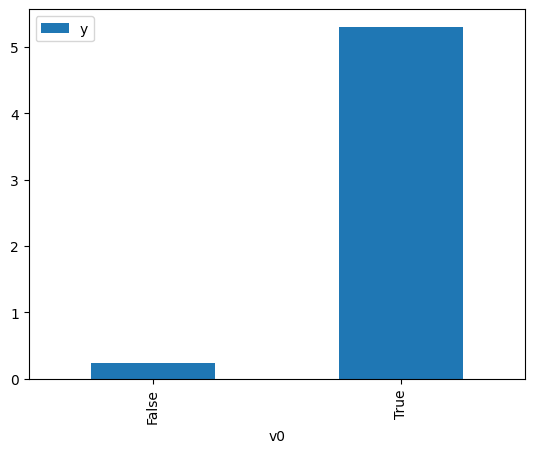

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

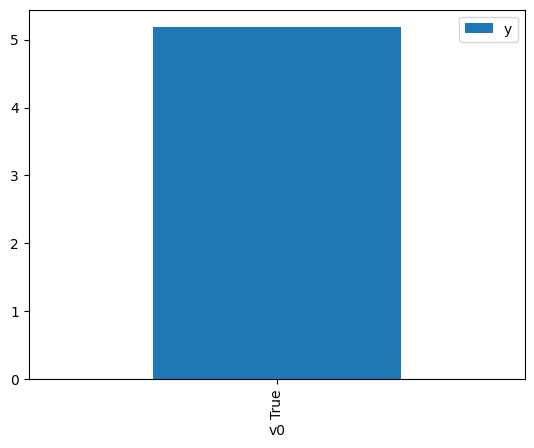

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.308303,False,0.116040,0.482067,2.074400
1,-1.263053,False,-1.817951,0.606521,1.648749
2,0.121694,False,0.730274,0.497037,2.011923
3,-0.988723,False,-3.008437,0.585317,1.708477
4,0.598545,False,0.983985,0.458858,2.179325
...,...,...,...,...,...
995,0.596091,False,0.991961,0.459053,2.178396
996,-0.124481,False,-0.328659,0.516789,1.935027
997,0.420481,False,2.690882,0.473082,2.113798
998,0.369409,False,0.048486,0.477171,2.095685


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.391905,True,9.102869,0.603398,1.657281
1,0.701586,True,5.321391,0.549345,1.820351
2,1.781753,True,7.299390,0.632929,1.579957
3,-1.521417,True,1.281636,0.373869,2.674736
4,0.567684,True,7.415414,0.538681,1.856386
...,...,...,...,...,...
995,-1.079316,True,2.394417,0.407642,2.453134
996,0.296304,True,5.358272,0.516971,1.934344
997,0.341964,True,5.234203,0.520630,1.920748
998,-0.502447,True,5.579233,0.453008,2.207465


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9828.
Date:                Fri, 21 Jul 2023   Prob (F-statistic):                        0.00
Time:                        19:17:56   Log-Likelihood:                         -1418.1
No. Observations:                1000   AIC:                                      2840.
Df Residuals:                     998   BIC:                                      2850.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7980      0.031     58.515      0.000       1.738       1.858
x2             5.0723      0.046    111.232      0.000       4.983       5.162
==============================================================================
Omnibus:                        4.729   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                4.846
Skew:                          -0.116   Prob(JB):                       0.0886
Kurtosis:                       3.249   Cond. No.                         1.58
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""